In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:93% !important; }</style>"))

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
import os
from os.path import join

# Read in Data

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow import keras

#image size
img_rows, img_cols = 28, 28

#ten possible digits (classes), 0,1,2,3,4,5,6,7,8,9
num_classes = 10

#training data has x and y (labels)
def prep_data(raw):
    y = raw[:, 0]
    out_y = keras.utils.to_categorical(y, num_classes)
    
    x = raw[:,1:]
    num_images = raw.shape[0]
    out_x = x.reshape(num_images, img_rows, img_cols, 1)
    out_x = out_x / 255
    return out_x, out_y

#test data only has x
def prep_data_test(raw_test): #only has x, no labels
    x = raw_test[:,0:]
    num_images = raw_test.shape[0]
    out_x = x.reshape(num_images, img_rows, img_cols, 1)
    out_x = out_x / 255
    return out_x

number_file = "https://storage.googleapis.com/computer-vision-smu-booth/booth_lecture/Digit%20Recognizer/digit-recognizer/train.csv"
number_data = np.loadtxt(number_file, skiprows=1, delimiter=',')
x, y = prep_data(number_data)

In [7]:
np.shape(x) #42,000 training images

(42000, 28, 28, 1)

In [8]:
#read and prep test data
number_file_test = "https://storage.googleapis.com/computer-vision-smu-booth/booth_lecture/Digit%20Recognizer/digit-recognizer/test.csv"
number_data_test = np.loadtxt(number_file_test, skiprows=1, delimiter=',')
x_test = prep_data_test(number_data_test)

In [9]:
np.shape(x_test) #28,000 test images

(28000, 28, 28, 1)

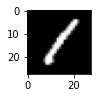

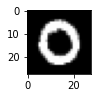

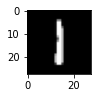

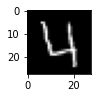

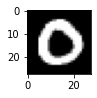

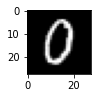

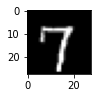

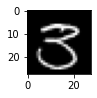

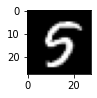

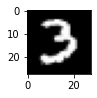

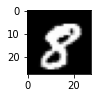

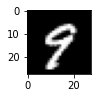

In [10]:
import matplotlib.pyplot as plt

#view a couple of the training images
for i in range(1,13):
    plt.subplot(3,4,i)
    plt.imshow(x[i-1].reshape([28,28]),cmap="gray")
    plt.show()

# Basic CNN

In [11]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D

#build the model
number_model = Sequential()
number_model.add(Conv2D(12, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1))) #activation layer

#additional learning layers
number_model.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))
number_model.add(Conv2D(25, kernel_size=(3, 3), activation='relu'))
number_model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
number_model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))

#final prediction layers
number_model.add(Flatten())
number_model.add(Dense(100, activation='relu'))
number_model.add(Dense(num_classes, activation='softmax'))

#compile the model
number_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
#initial fit with validation
history = number_model.fit(x, y,
          batch_size=100,
          epochs=1,
          validation_split = 0.2)

336/336 [==============================] - 83s 242ms/step - loss: 0.2347 - accuracy: 0.9304 - val_loss: 0.0784 - val_accuracy: 0.9756


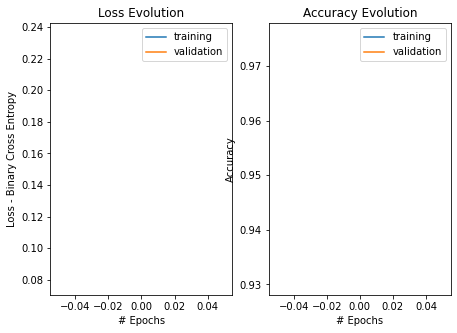

In [13]:
#https://www.kaggle.com/pheaboo/simple-cnn-trained-from-scratch
plt.figure(figsize=(15,5))

plt.subplot(141)
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('# Epochs')
plt.legend()
plt.ylabel("Loss - Binary Cross Entropy")
plt.title('Loss Evolution')

plt.subplot(142)
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('# Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy Evolution')
plt.show()

# See how it does on the Validation Set

In [14]:
#Get predictions
preds_test = number_model.predict(x_test)
#the model returns a list of probabilities for each number the image could be. 
#argmax is a hack to get the most likely number
realPreds = [np.argmax(x) for x in preds_test]
realPreds[0:12]

[2, 0, 9, 9, 3, 9, 0, 3, 0, 3, 5, 7]

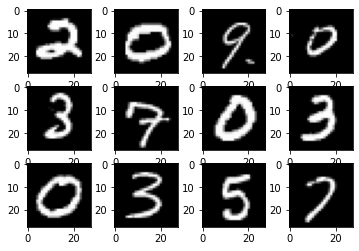

In [15]:
#print a few of the test numbers to look at our predictions
for i in range(1,13):
    plt.subplot(3,4,i) #sub plots have to start at 1
    plt.imshow(x_test[i-1].reshape([28,28]),cmap="gray")
    
#looks like we are missing the fourth number

# Retrain using Image Augmentation (rotations, scaling)

In [16]:
#have to manually get our validation data when dealing with generators
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2)

In [17]:
#build the model, same as above
number_model_aug = Sequential()
number_model_aug.add(Conv2D(12, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1))) #activation layer

#additional learning layers
number_model_aug.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
number_model_aug.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
number_model_aug.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
number_model_aug.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))

#final prediction layers
number_model_aug.add(Flatten())
number_model_aug.add(Dense(100, activation='relu'))
number_model_aug.add(Dense(num_classes, activation='softmax'))

#compile the model
number_model_aug.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [19]:
history2 = number_model_aug.fit_generator(datagen.flow(X_train,Y_train),
                              epochs = 5, validation_data = (X_val,Y_val), steps_per_epoch=20)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


20/20 [==============================] - 9s 410ms/step - loss: 1.9413 - accuracy: 0.3375 - val_loss: 1.0288 - val_accuracy: 0.6538
Epoch 2/5
20/20 [==============================] - 8s 404ms/step - loss: 1.2771 - accuracy: 0.5609 - val_loss: 0.5428 - val_accuracy: 0.8306
Epoch 3/5
20/20 [==============================] - 8s 391ms/step - loss: 0.9162 - accuracy: 0.6969 - val_loss: 0.5628 - val_accuracy: 0.8329
Epoch 4/5
20/20 [==============================] - 8s 402ms/step - loss: 0.7834 - accuracy: 0.7328 - val_loss: 0.3374 - val_accuracy: 0.9037
Epoch 5/5
20/20 [==============================] - 8s 411ms/step - loss: 0.7226 - accuracy: 0.7844 - val_loss: 0.3080 - val_accuracy: 0.9052


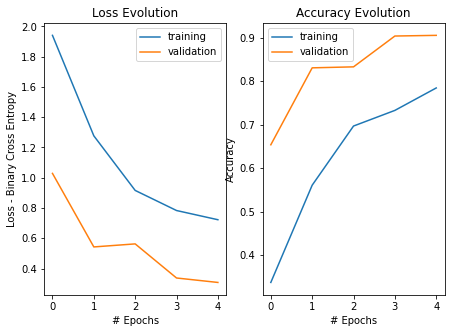

In [20]:
#https://www.kaggle.com/pheaboo/simple-cnn-trained-from-scratch
plt.figure(figsize=(15,5))

plt.subplot(141)
plt.plot(history2.history['loss'], label='training')
plt.plot(history2.history['val_loss'], label='validation')
plt.xlabel('# Epochs')
plt.legend()
plt.ylabel("Loss - Binary Cross Entropy")
plt.title('Loss Evolution')

plt.subplot(142)
plt.plot(history2.history['accuracy'], label='training')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.xlabel('# Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy Evolution')
plt.show()

In [21]:
#Get predictions
preds_test_aug = number_model_aug.predict(x_test)
#the model returns a list of probabilities for each number the image could be. 
#argmax is a hack to get the most likely number
real_preds_aug = [np.argmax(x) for x in preds_test_aug]
real_preds_aug[0:12]

[2, 0, 9, 7, 3, 7, 0, 3, 0, 3, 5, 7]

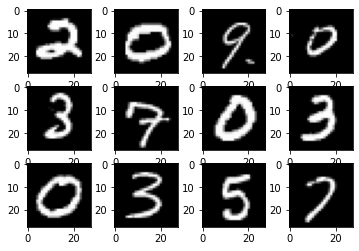

In [22]:
#print a few of the test numbers to look at our predictions
for i in range(1,13):
    plt.subplot(3,4,i) #sub plots have to start at 1
    plt.imshow(x_test[i-1].reshape([28,28]),cmap="gray")
    
#looks like we are still missing the 4th number

In [23]:
# Save test predictions to file
# no aug performed better
output = pd.DataFrame({'ImageId': range(1,28001),
                       'Label': realPreds})
output.to_csv('submission.csv', index=False)

In [24]:
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
